![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/Seal_of_the_United_States_Space_Force.svg/240px-Seal_of_the_United_States_Space_Force.svg.png)

# Orbit Simulation

This is a trivial simulation of orbital dynamics.

## Conventions

- R: vector R having x,y,z components
- r: scalar magnitude of R: $r = \sqrt{x^2 + y^2 + z^2}$

## Energy

Total mechanical energy is the sum of kinetic energy (KE) and potential energy (PE):

$$
E = KE + PE = \frac{1}{2}mV^2 + \frac{m\mu}{r}
$$

The angular momentum (without any pertibations like drag) is constant.

$$
H = R \times V
$$

## Two Body Motion and Peritibation

$$
\ddot R + \frac{\mu}{r^3}R = a_D
$$

where $a_D$ are forces that pertibate the orbit like drag. A simple model for drag is:

$$
a_D = -\frac{1}{2} \rho v^2 \frac{c_D a}{m}i_v
$$

where $\rho$ is the atmosphere density, $v$ is the scalar velocity of the satellite in the direction of travel, $A$ is the effective (projected) area of the satellite, $m$ is the satellite mass, and $i_v$ is the unit vector of the satelite velocity.

The term $\frac{m}{c_D a}$ is also known as the balistic coefficient (BC).

$$
a_D = -\frac{1}{2} \frac{\rho v^2}{BC}i_v
$$

- **High BC:** little atomopheric drag and longer life in low orbit. Vehicle re-entry is fast with high velocity impact (good for making big holes in the ground). This is easily seen in the equation above; as the demoninator becomes larger, the term $a_D$ becomes smaller
- **Low BC:** higher drag and reduced life-time for low orbiting satellites that cannot perform orbital maintenance maneuvers to boost themselves higher. Vehicles re-entering will hit subsonic speeds before the reaching ground and this is typical of vehicles carrying humans back from space.

### Others

- $J_2$ are the second harmonic and the effects are due to the oblatness of the Earth. This results in a percession of RAAN ($\Omega$) and argument of perigee ($\omega$).
- $J_3$ effects the third homonic and affect the inclination and the eccentricity of the orbit

# References

- Wikipedia: [Ballistic coefficients](https://en.wikipedia.org/wiki/Ballistic_coefficient)
- Useful [formulas](https://elainecoe.github.io/orbital-mechanics-calculator/formulas.html) for orbits and astrodynamics
- Vladimir Chobotov, "Orbital Mechanices 3rd Ed"
    - $J_2$ effects, pg 215
    - $J_3$ effects, pg 220

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import pi, sqrt, sin, cos
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import time
from pyrk import RK4

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def twobody(t,X,u,params=None):
    """
    X=[R,V]
    """
    R = X[:3]
    r = np.linalg.norm(R)
    mu = Earth.mu #km^3/sec^2
    
    dx = np.zeros(6)
    dx[:3] = X[3:6]       # Rdot = V
    dx[3:] = -mu*R/(r**3) # Vdot = accelerations/forces
    
    return dx

In [4]:
def twobody_drag(t,X,u,params=None):
    """
    X=[R,V]
    """
    R = X[:3]
    r = np.linalg.norm(R)
    mu = Earth.mu #km^3/sec^2
    
    v = np.linalg.norm(X[3:6])
    i = X[3:6]/v
    A = 10e-6  # km^2
    m = 500 # kg
    rho = 4e-4 # kb/km^3
    cd = 1
    D = -1/2*rho*v**2*(cd*A)/m*i
    
    dx = np.zeros(6)
    dx[:3] = X[3:6]         # Rdot = V
    dx[3:] = -mu*R/(r**3)-D # Vdot = accelerations/forces
    
    return dx

In [47]:
from doop.constants import Earth
# from doop.objects import coe2rv
from doop import COE

In [48]:
# >> Pos[km]: [7000.2    0.     0. ]   Vel[km/s]: [0.    7.914 0.   ]
# 7000.2

coe = COE(7000, 0.01, 0, 0, 0,0)
rr = coe.a*(1-coe.e**2)/(1+coe.e*cos(coe.v*pi/180))
vv = sqrt(Earth.mu*(2/rr-1/coe.a))
print(f">> COE R: {rr:.1f} km   Vel: {vv:.1f} km/sec   Altitude: {rr-Earth.radius:.1f} km")

# r,v = coe2rv(*coe)
r,v = coe.to_rv()
print(f">> Pos[km]: {r}   Vel[km/s]: {v}")
x = np.hstack((r,v))

>> COE R: 6930.0 km   Vel: 7.6 km/sec   Altitude: 551.6 km
>> Pos[km]: [6930.    0.    0.]   Vel[km/s]: [0.    7.622 0.   ]


In [49]:
cc = COE.from_rv(r,v)
print(cc)
print(f">> Pos[km]: {cc.r}   Vel[km/s]: {cc.velocity}")
print(f">> Period: {cc.period:.1f} sec  {cc.period/60:.1f} mins")

a: 7000.0km e: 0.0100 i: 0.0° RAAN: 0.0° w: 360.0° v: 0.0°
>> Pos[km]: 6930.000000000001   Vel[km/s]: 7.621894927282825
>> Period: 5828.5 sec  97.1 mins


In [19]:
tle = """ISS (ZARYA)
1 25544U 98067A   20060.61908565  .00000737  00000-0  21434-4 0  9993
2 25544  51.6436 165.6500 0005418 332.6966 228.1099 15.49204316215186"""

cc = COE.from_tle(tle)
print(cc)
print(f">> Pos[km]: {cc.r}   Vel[km/s]: {cc.velocity}")
print(f">> Period: {cc.period:.1f} sec  {cc.period/60:.1f} mins")

unknown ephemeris type: 0
COE(a=6797.1894682451375, e=0.0005418, i=51.6436, raan=165.65, w=332.6966, v=228.1099)
>> Pos[km]: 6799.647326920644   Vel[km/s]: 7.655034624168856
>> Period: 5577.1 sec  93.0 mins


In [175]:
rk = RK4(twobody)

dt = 1
tx = 0

t = []
y = []

# orbital period
T = 2*pi*sqrt(coe.a**3/Earth.mu)
print(f">> Period of orbit: {T:.1f} sec or {T/60:.1f} mins")

for i in range(int(T//dt)):
    x = rk.step(x,None,tx, dt)
    
    y.append(x)
    t.append(tx/60)
    
    tx += dt

>> Period of orbit: 5828.5 sec or 97.1 mins


<IPython.core.display.Javascript object>


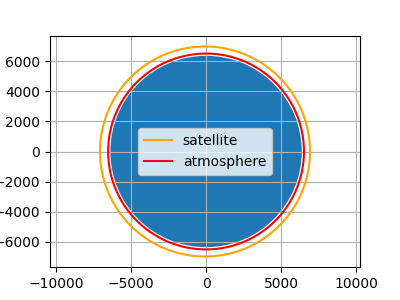

In [176]:
plt.figure(figsize=(4,3))
ax = plt.gca()

# plot orbit
ax.plot(
    [x[0] for x in y],
    [x[1] for x in y],
    color="orange",
    label="satellite"
)

# plot atmosphere
atmos = Earth.radius+150
ax.plot(
    atmos*np.cos(np.array(range(361))*np.pi/180), 
    atmos*np.sin(np.array(range(361))*np.pi/180),
    color="red",
    label="atmosphere"
)

earth = Circle(xy=(0,0), radius=Earth.radius)
ax.add_patch(earth)
ax.axis("equal")
ax.grid(True)
ax.legend();

<IPython.core.display.Javascript object>


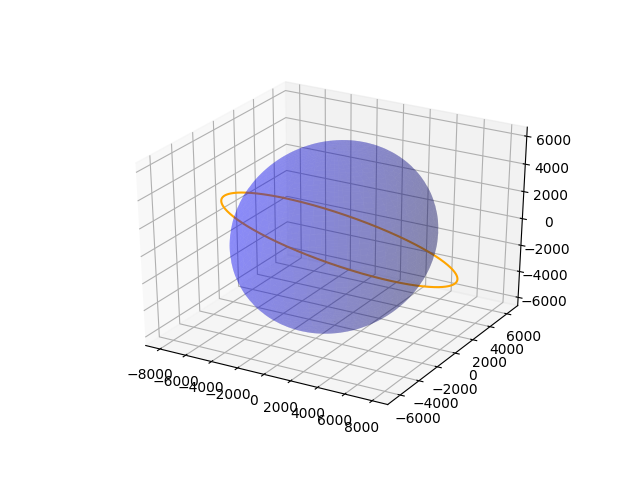

In [141]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    [x[0] for x in y],
    [x[1] for x in y],
    [x[2] for x in y],
    color="orange",
    label="satellite"
)

# Make data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
ex = Earth.radius * np.outer(np.cos(u), np.sin(v))
ey = Earth.radius * np.outer(np.sin(u), np.sin(v))
ez = Earth.radius * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(ex, ey, ez, color='b', alpha=0.25)

# ax.axis("equal")
ax.grid(True);

<IPython.core.display.Javascript object>


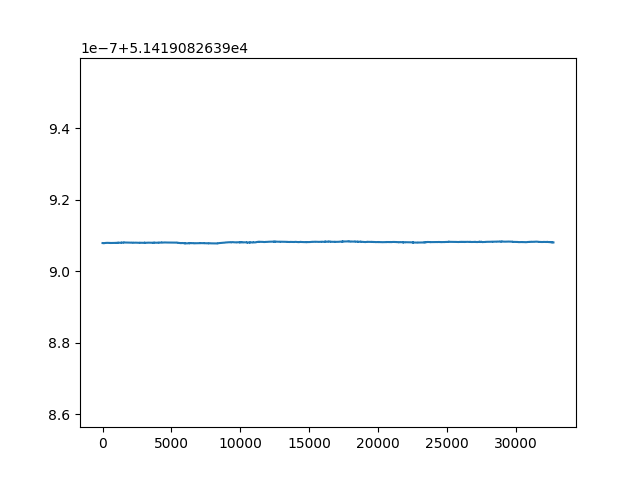

In [158]:
plt.plot([np.linalg.norm(np.cross(x[:3], x[3:6])) for x in y])

In [156]:
h = [np.linalg.norm(np.cross(x[:3], x[3:6])) for x in y]

<IPython.core.display.Javascript object>


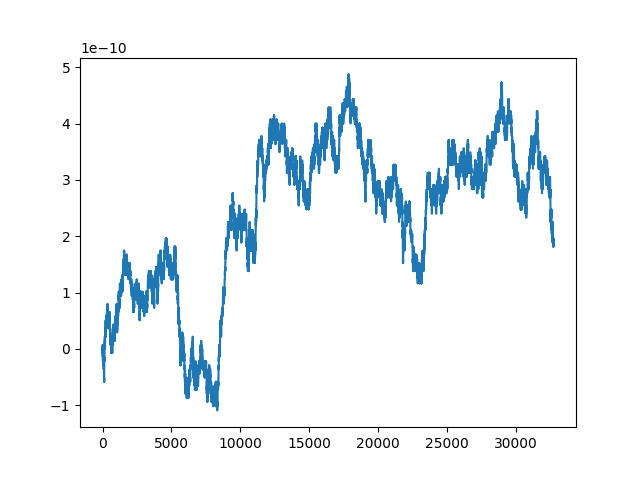

In [157]:
plt.plot([x-h[0] for x in h])

In [151]:
plt.plot(range(3))

# COEs

In [92]:
from doop import COE
from doop.objects import get_coes

In [93]:
coe = COE(7000, 0.01, 0, 0, 0,0)
rr = coe.a*(1-coe.e**2)/(1+coe.e*cos(coe.v*pi/180))
vv = sqrt(Earth.mu*(2/rr-1/coe.a))
print(f">> COE R: {rr:.1f} km   Vel: {vv:.1f} km/sec   Altitude: {rr-Earth.radius:.1f} km")

r,v = coe.to_rv()
print(f">> Pos[km]: {r}   Vel[km/s]: {v}")
x = np.hstack((r,v))

>> COE R: 6930.0 km   Vel: 7.6 km/sec   Altitude: 551.6 km
>> Pos[km]: [6930.    0.    0.]   Vel[km/s]: [0.    7.622 0.   ]


In [100]:
coes = get_coes("gps")
for c in coes[:10]:
    print(c.tle.object.name, c)

>> Found 32 TLEs

*** not enough values to unpack (expected 3, got 1) ***
GPS BIIR-2  (PRN 13)     a: 26560.2km e: 0.0039 i: 55.5° RAAN: 185.2° w: 60.6° v: 299.9°
GPS BIIR-3  (PRN 11)     a: 26560.8km e: 0.0158 i: 52.3° RAAN: 31.1° w: 114.1° v: 356.9°
GPS BIIR-4  (PRN 20)     a: 26560.1km e: 0.0050 i: 53.5° RAAN: 110.2° w: 154.8° v: 272.6°
GPS BIIR-5  (PRN 28)     a: 26560.2km e: 0.0186 i: 56.0° RAAN: 303.2° w: 279.3° v: 262.2°
GPS BIIR-6  (PRN 14)     a: 26560.1km e: 0.0116 i: 55.0° RAAN: 182.5° w: 250.6° v: 120.8°
GPS BIIR-8  (PRN 16)     a: 26561.2km e: 0.0114 i: 56.1° RAAN: 303.0° w: 35.3° v: 146.8°
GPS BIIR-9  (PRN 21)     a: 26575.5km e: 0.0242 i: 54.6° RAAN: 54.0° w: 283.9° v: 292.6°
GPS BIIR-10 (PRN 22)     a: 26558.6km e: 0.0074 i: 53.3° RAAN: 113.0° w: 292.7° v: 66.5°
GPS BIIR-11 (PRN 19)     a: 26560.4km e: 0.0092 i: 56.3° RAAN: 3.8° w: 92.9° v: 78.8°
GPS BIIR-12 (PRN 23)     a: 26575.5km e: 0.0144 i: 54.1° RAAN: 176.5° w: 235.2° v: 4.7°


In [101]:
coes = get_coes("stations")
for c in coes[:10]:
    print(c.tle.object.name, c)

>> Found 71 TLEs
CYGNUS NG-13            
1 45175U 20011A   20145.65484343 -.00007419  00000-0 -24901-3 0  9997
2 45175  51.6476 106.6303 0005501  15.0687 143.8857 15.28773067 15299
*** list index out of range ***

*** not enough values to unpack (expected 3, got 1) ***
ISS (ZARYA)              a: 6796.7km e: 0.0001 i: 51.6° RAAN: 107.1° w: 344.5° v: 30.9°
KESTREL EYE IIM (KE2M)   a: 6738.4km e: 0.0003 i: 51.6° RAAN: 45.5° w: 18.7° v: 341.4°
DELLINGR (RBLE)          a: 6736.6km e: 0.0001 i: 51.6° RAAN: 44.1° w: 19.5° v: 340.6°
1KUNS-PF                 a: 6643.5km e: 0.0004 i: 51.6° RAAN: 19.8° w: 225.1° v: 135.0°
UBAKUSAT                 a: 6724.9km e: 0.0001 i: 51.6° RAAN: 47.6° w: 92.3° v: 267.9°
CUBERRT                  a: 6729.3km e: 0.0003 i: 51.6° RAAN: 47.2° w: 18.3° v: 341.8°
TEMPEST-D                a: 6759.3km e: 0.0005 i: 51.6° RAAN: 75.1° w: 335.5° v: 24.6°
RAINCUBE                 a: 6728.3km e: 0.0004 i: 51.6° RAAN: 56.2° w: 20.6° v: 339.5°
HALOSAT                  a: 673

In [118]:
for x in coes[0].tle._fields:
    print(f"{x}: {getattr(coes[0].tle, x)}")

object: Object(name='ISS (ZARYA)             ', number=25544, classification='Unclassified')
id: ID(launch_year=1998, launch_number='067', piece='A')
coe: OE(a=6796.660695822771, e=0.0001435, i=51.6454, raan=107.0779, w=344.5321, v=30.8943)
ballistic_coeffecient: 3.27e-06
bstar: 1.3912
line1: 1 25544U 98067A   20145.22319454  .00000327  00000-0  13912-4 0  9994
line2: 2 25544  51.6454 107.0779 0001435 344.5321  30.8943 15.49385109228300


In [107]:
coes[0].tle._fields

('object', 'id', 'coe', 'ballistic_coeffecient', 'bstar', 'line1', 'line2')

In [112]:
dir(coes[0].tle)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_field_defaults',
 '_fields',
 '_fields_defaults',
 '_make',
 '_replace',
 'ballistic_coeffecient',
 'bstar',
 'coe',
 'count',
 'id',
 'index',
 'line1',
 'line2',
 'object']

In [114]:
m=coes[0].tle
m

TLE(object=Object(name='ISS (ZARYA)             ', number=25544, classification='Unclassified'), id=ID(launch_year=1998, launch_number='067', piece='A'), coe=OE(a=6796.660695822771, e=0.0001435, i=51.6454, raan=107.0779, w=344.5321, v=30.8943), ballistic_coeffecient=3.27e-06, bstar=1.3912, line1='1 25544U 98067A   20145.22319454  .00000327  00000-0  13912-4 0  9994', line2='2 25544  51.6454 107.0779 0001435 344.5321  30.8943 15.49385109228300')

In [116]:
m._asdict()

{'object': Object(name='ISS (ZARYA)             ', number=25544, classification='Unclassified'),
 'id': ID(launch_year=1998, launch_number='067', piece='A'),
 'coe': OE(a=6796.660695822771, e=0.0001435, i=51.6454, raan=107.0779, w=344.5321, v=30.8943),
 'ballistic_coeffecient': 3.27e-06,
 'bstar': 1.3912,
 'line1': '1 25544U 98067A   20145.22319454  .00000327  00000-0  13912-4 0  9994',
 'line2': '2 25544  51.6454 107.0779 0001435 344.5321  30.8943 15.49385109228300'}